In [112]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rc('font', size=12)

from numba import njit

# Voter model with mutation

In [113]:
@njit
def init_grid(L):
    '''Initialises an L by L grid with numbers drawn randomly from (0, 1)'''
    return np.random.rand(L, L)

In [114]:
@njit
def get_4_neighbors(i, j, L):
    '''Finds upper, lower, left and right neighbor of a site in a K by K grid'''
    neighbors = []
    # Up, down, right, left
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  
    for di, dj in directions:
        # Apply periodic boundary conditions
        neighbor_i = int((i + di) % L)
        neighbor_j = int((j + dj) % L)
        neighbors.append((neighbor_i, neighbor_j))
    return neighbors

In [115]:
def sa_curve(grid):
    height, width = grid.shape
    
    n_centers = 10
    centers_x = np.random.choice(np.arange(0, width), n_centers) + width
    centers_y = np.random.choice(np.arange(0, height), n_centers) + height

    areas = []
    species = []
    
    torus_grid = np.vstack((grid, grid, grid))
    torus_grid = np.hstack((torus_grid, torus_grid, torus_grid))
        
    for i, (x, y) in enumerate(zip(centers_x, centers_y)):
        cur_species = []
        for j in range(width//2):
            cur_species.append(len(np.unique(torus_grid[x-j:x+j+1, y-j:y+j+1])))
            if i == 0:
                areas.append((j+1)**2)
        species.append(cur_species)
    
    return areas, species

In [116]:
import random
import itertools

def voter_model(L, alpha, MC_steps, rand_walkers):
    '''Run experiment with the voter model
    Inputs:
    grid_0 (numpy array): Initial grid
    alpha (float): Value of alpha parameter
    MC_steps (int): number of monte carlo steps
    
    Returns:
    cur_grid (numpy array): Grid after n_iter iterations
    num_species (list): Contains amount of different species at each tenth iteration
    '''
    # Create list to store number of unique species
    num_species = []
    
    lineages = [[element] for element in rand_walkers]
    species = []

    # Update grid n_iter times
    for i in range(MC_steps):
        for _ in range(len(rand_walkers)):
            if len(lineages) == 1:
                species.append(lineages[0])
                break
            
            cur_walker_idx = random.choice(range(len(lineages)))
            cur_walker = lineages[cur_walker_idx]
            cur_pos = cur_walker[-1]
            parent_coords = random.choice(get_4_neighbors(cur_pos[0], cur_pos[1], L))
            
            for j, lineage in enumerate(lineages):
                in_lin = False
                if parent_coords in lineage:
                    in_lin = True
                    if random.random() < alpha:
                        species.append(lineages[cur_walker_idx])
                        del lineages[cur_walker_idx]
                    else:
                        if j != cur_walker_idx:
                            lineages[j] = cur_walker + lineages[j]
                            del lineages[cur_walker_idx]
                        else:
                            lineages[cur_walker_idx].remove(parent_coords)
                            lineages[cur_walker_idx].append(parent_coords)
                    break
            if not in_lin:
                for j, specie in enumerate(species):
                    if parent_coords in specie:
                        species[j] = cur_walker + species[j]
                        del lineages[cur_walker_idx]
                        
        if len(lineages) == 1:
            species.append(lineages[0])
            break
            
    return species, lineages, i

In [127]:
import random
import itertools

def voter_model_fast(L, alpha, MC_steps, rand_walkers):
    '''Run experiment with the voter model
    Inputs:
    grid_0 (numpy array): Initial grid
    alpha (float): Value of alpha parameter
    MC_steps (int): number of monte carlo steps
    
    Returns:
    cur_grid (numpy array): Grid after n_iter iterations
    num_species (list): Contains amount of different species at each tenth iteration
    '''
    # Create list to store number of unique species
    
    lineages = [[element] for element in rand_walkers]
    rand_walker_pos = list(rand_walkers.copy())
    species = []
    
    for i in range(MC_steps):
        for _ in range(L**2):
            if len(rand_walker_pos) == 0:
                return lineages, species, rand_walker_pos, i
            
            cur_walker = random.choice(rand_walker_pos)
            cur_walker_idx = L*cur_walker[0] + cur_walker[1]
            parent_walker = random.choice(get_4_neighbors(cur_walker[0], cur_walker[1], L))
            parent_walker_idx = L*parent_walker[0] + parent_walker[1]
            
            if random.random() < alpha:
                species.append(lineages[cur_walker_idx])
                rand_walker_pos.remove(cur_walker)
                lineages[cur_walker_idx] = len(species) - 1
            else:
                if type(lineages[parent_walker_idx]) == list:
                    if parent_walker not in lineages[cur_walker_idx]:
                        lineages[cur_walker_idx] = lineages[cur_walker_idx] + lineages[parent_walker_idx]
                        lineages[parent_walker_idx] = lineages[parent_walker_idx] + lineages[cur_walker_idx]
                    else:
                        if parent_walker not in rand_walker_pos:
                            rand_walker_pos.append(parent_walker)
                        
                elif type(lineages[parent_walker_idx]) == int:
                    species[lineages[parent_walker_idx]] = species[lineages[parent_walker_idx]] + lineages[cur_walker_idx]
                    lineages[cur_walker_idx] = lineages[parent_walker_idx]
                    rand_walker_pos.remove(cur_walker)
        
    return lineages, species, rand_walker_pos, i

In [128]:
# Define parameters as in paper
alpha = 10e-5
L = 150

MC_steps = int(1e5)
rand_walkers = list(itertools.product(range(L), range(L)))

lineages, species, rand_walker_pos, i = voter_model_fast(L, alpha, MC_steps, rand_walkers)

In [129]:
print(len(rand_walker_pos), i)

0 31


In [130]:
species_ids = np.random.uniform(size=len(species))

grid = np.zeros((L, L))
for i, specie in enumerate(species):
    for coord in specie:
        grid[coord] = species_ids[i]

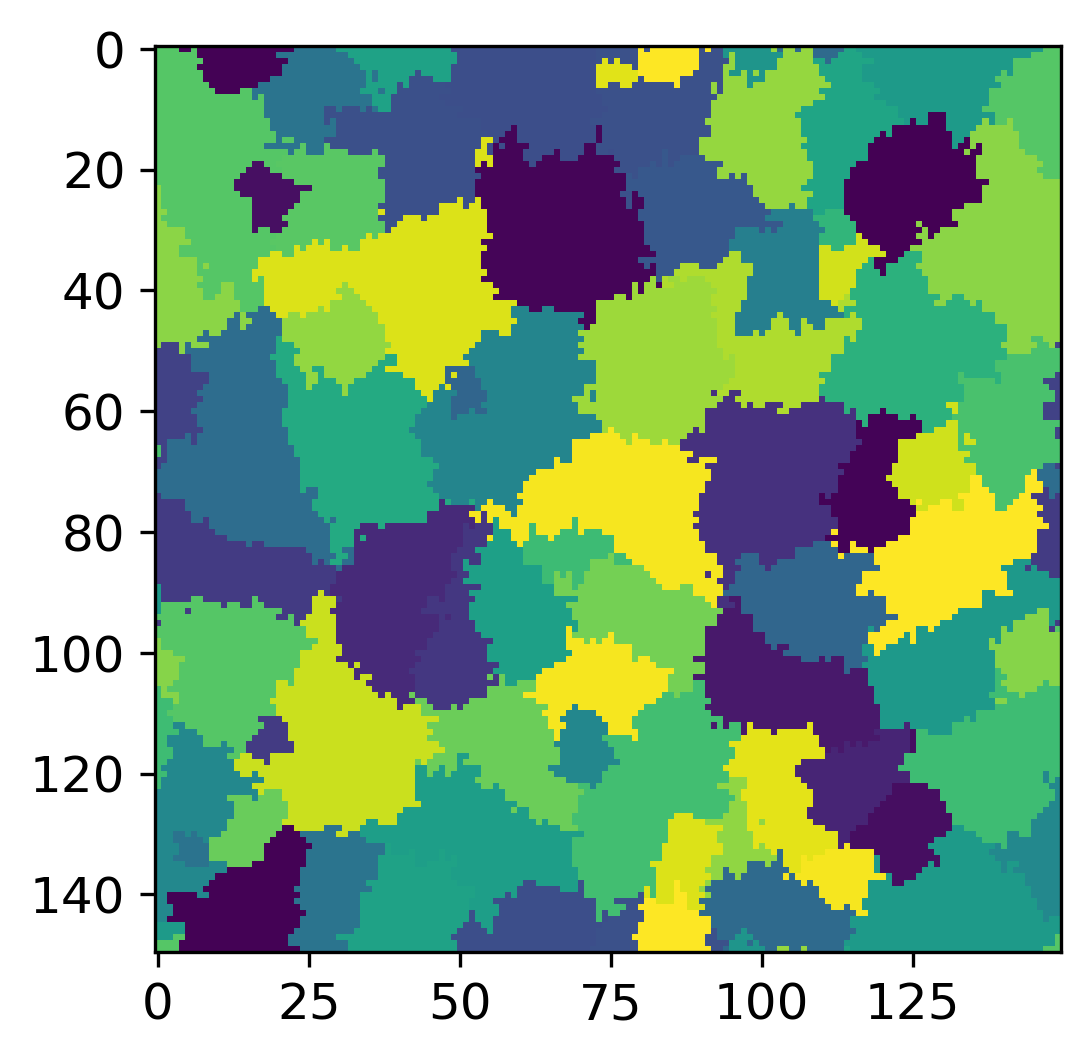

In [131]:
plt.imshow(grid)
plt.show()

[ 0.59331702 -0.94117581]


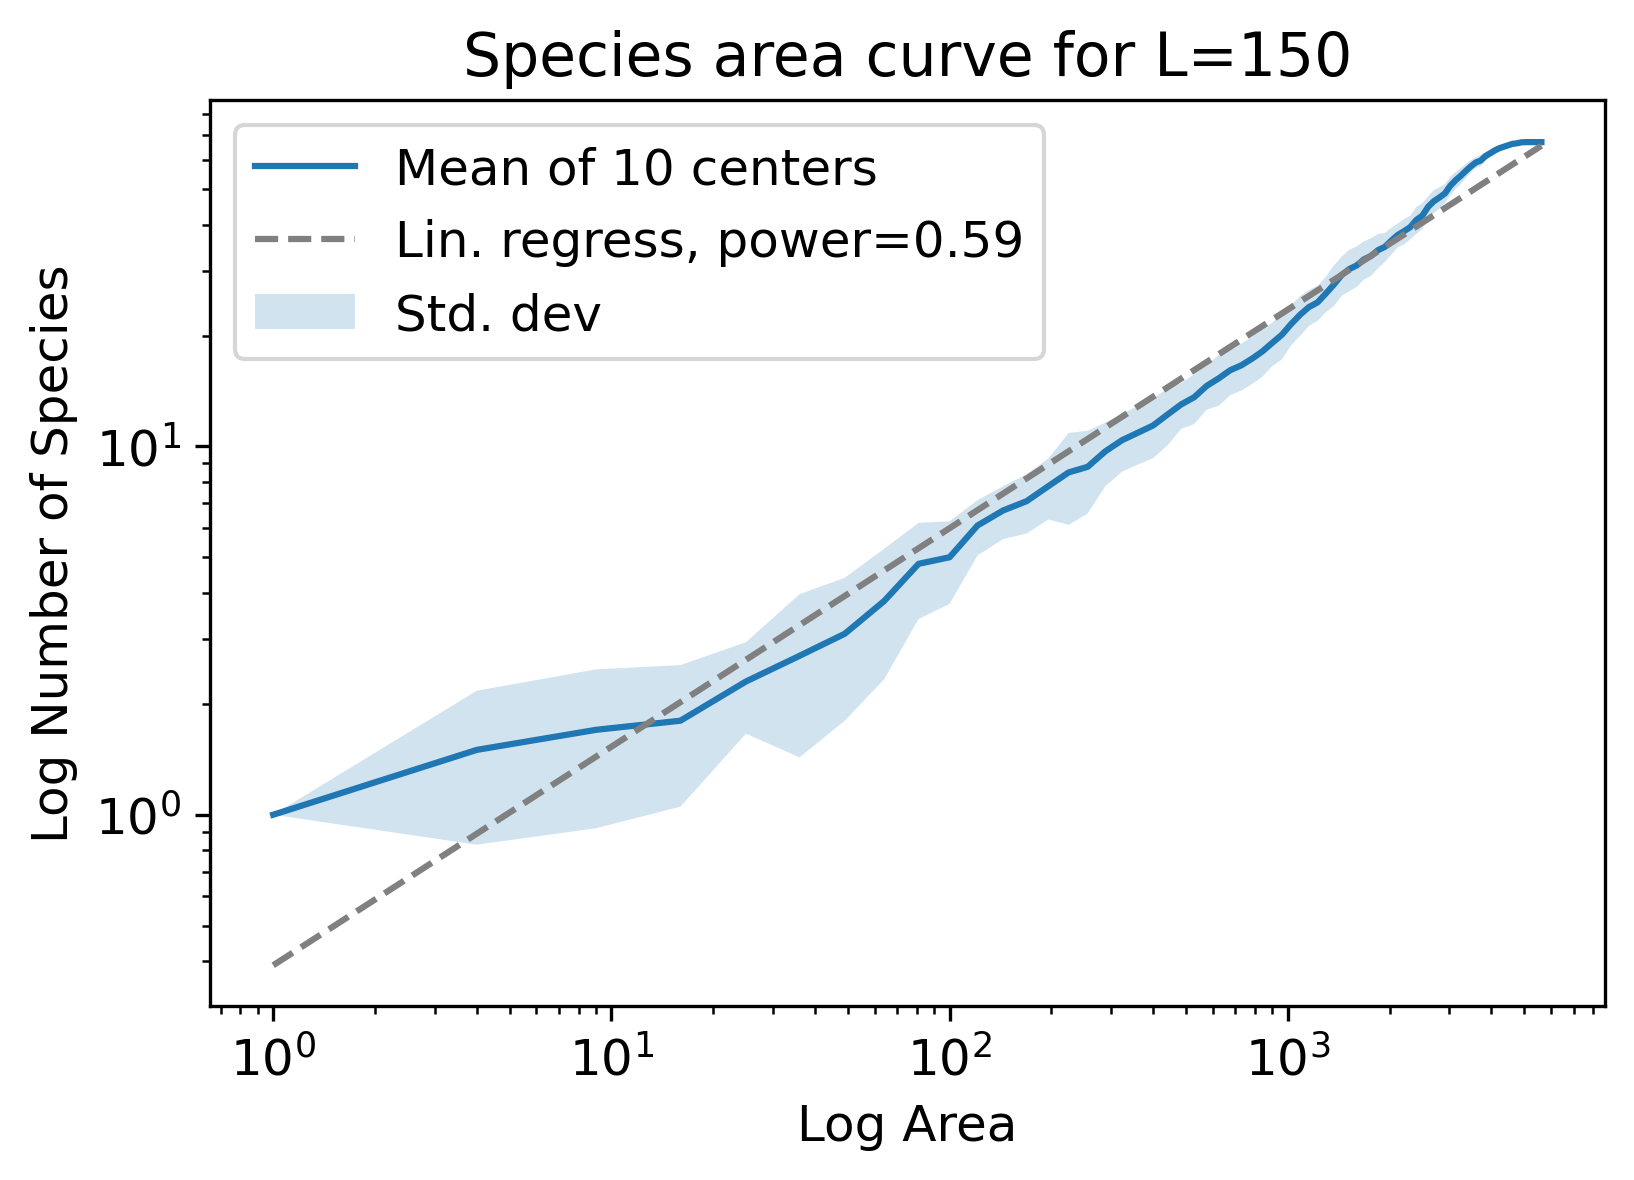

In [132]:
areas, species = sa_curve(grid)
spec_std_dev = np.std(species, axis=0)
spec_mean = np.mean(species, axis=0)

poly_coeffs = np.polyfit(np.log(areas), np.log(spec_mean), 1)
print(poly_coeffs)

plt.loglog(areas, spec_mean, label='Mean of 10 centers')
plt.loglog([areas[0], areas[-1]], 
           np.exp(poly_coeffs[1]) * np.array([areas[0], areas[-1]])**poly_coeffs[0], 
           color='grey', 
           linestyle='dashed',
           label=f'Lin. regress, power={round(poly_coeffs[0], 2)}')
plt.fill_between(areas, spec_mean-spec_std_dev, spec_mean+spec_std_dev, alpha=0.2, label='Std. dev')
plt.ylabel('Log Number of Species')
plt.xlabel('Log Area')
plt.title(f'Species area curve for L={L}')
plt.legend()
plt.show()